In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:

from scipy.stats import rv_continuous
from scipy.interpolate import interp1d
from matplotlib.patches import Circle
from scipy.special import gamma
import numpy as np
import emcee
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad
import matplotlib.patches as patches
from itertools import product
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
from matplotlib.colors import LogNorm

In [3]:
path = "/data/OWN/DMO/mochima2/output_00041"
Z4= wkbl.Galaxy_Hound(path)
print "loaded"
Z4.r_virial(600)
print "cutted"


loading Dark matter..
Dark matter loaded..
loaded
cutted


In [4]:
ok,Z4.dm.rho,_= CF.getDensity(np.array(Z4.dm.pos3d.reshape(len(Z4.dm.pos3d)*3),
                                    dtype=np.float32), Z4.dm.mass)


In [5]:
path = "/data/OWN/DMO/mochima2_Z5/output_00041"
Z5= wkbl.Galaxy_Hound(path)
print "loaded"
Z5.r_virial(600)
print "cutted"

loading Dark matter..
Dark matter loaded..
loaded
cutted


In [6]:
ok,Z5.dm.rho,_= CF.getDensity(np.array(Z5.dm.pos3d.reshape(len(Z5.dm.pos3d)*3),
                                    dtype=np.float32), Z5.dm.mass)


In [1]:
def face_on_dm(sim,lims,points):
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.dm.pos3d[:,0], 
                                       sim.dm.pos3d[:,1],
                                       bins=(edges, edges),
                                       weights=sim.dm.mass)
    result = H.T
    return result, edges

<IPython.core.display.Javascript object>


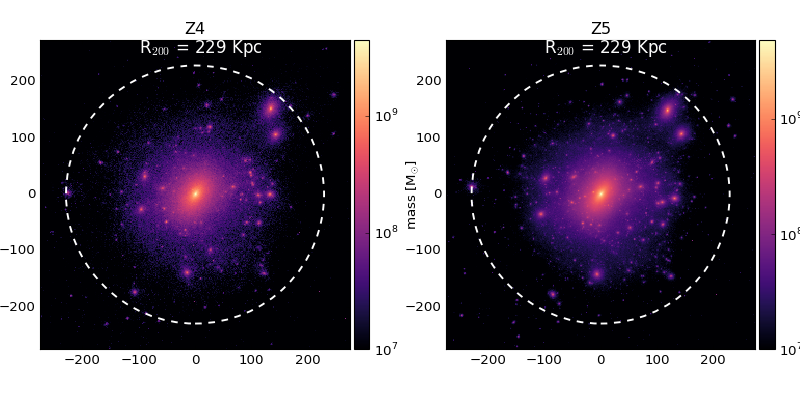

In [14]:


face_on_z4, edges = face_on_dm(Z4,[-1.2*Z4.r200,1.2*Z4.r200],300)
face_on_z5, edges = face_on_dm(Z5,[-1.2*Z4.r200,1.2*Z4.r200],300)
length = 15. 
fig,[ax,ax1] = plt.subplots(1,2,figsize=[10,5])
fig.tight_layout(w_pad=3)
ax.set_title("Z4")
ax1.set_title("Z5")

mass_1 = ax.imshow(face_on_z4+1e3, interpolation='nearest', origin='low',cmap="magma",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e7)
                  )
divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax,label=r'mass [M$_{\odot}$]')

ax.add_artist(Circle(xy=(0, 0),radius=Z4.r200,color='w',ls='--',lw=1.7,fill=False))
ax.text(-100,1.1*Z4.r200,r"R$_{200}$ = "+str(int(Z4.r200))+" Kpc ",color='w',fontsize=15)

mass_1 = ax1.imshow(face_on_z5+1e3, interpolation='nearest', origin='low',cmap="magma",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e7)
                  )
divider = make_axes_locatable(ax1)

cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax,label=r'mass [M$_{\odot}$]')

ax1.add_artist(Circle(xy=(0, 0),radius=Z5.r200,color='w',ls='--',lw=1.7,fill=False))
ax1.text(-100,1.1*Z5.r200,r"R$_{200}$ = "+str(int(Z5.r200))+" Kpc ",color='w',fontsize=15)

<IPython.core.display.Javascript object>


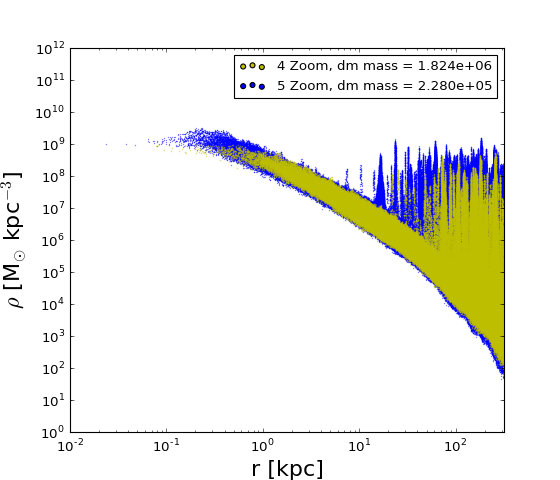

In [178]:
fig, ax= plt.subplots(figsize=[7,6])
ax.set_xlim([1e-2,10**2.5])
ax.set_ylim([1,1e12])
ax.scatter(Z5.dm.r, Z5.dm.rho,s=1.5,alpha=0.5,lw=0)
ax.scatter(Z4.dm.r, Z4.dm.rho,s=1.9,alpha=0.5,lw=0,c='y')
ax.scatter(1e20,1e20,c='y', label="4 Zoom, dm mass = {0:.3e}".format(Z4.dm.mass[0]))
ax.scatter(1e20,1e20,c='b', label="5 Zoom, dm mass = {0:.3e}".format(Z5.dm.mass[0]))


ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([1e0,1e12])
ax.set_xlabel(r"r [kpc]",fontsize=20)
ax.set_ylabel(r"$\rho$ [M$_{\odot}$ kpc$^{-3}$]",fontsize=20)
ax.set_title("",fontsize=15)
####
legend = ax.legend(loc='bottom left', ncol=1, shadow=False, fontsize=12)

In [216]:
Pcrit = Z5.dm._p.rho_crit
Mdm = Z5.dm.mass.min()
myradiuses = Z5.dm.r[np.argsort(Z5.dm.r)]
tabN = np.cumsum(np.ones(len(myradiuses)))[1:]
myradiuses = myradiuses[1:]
Rp03 = np.sqrt(200/64.) * np.sqrt(4 * np.pi * Pcrit * tabN / 3. / Mdm ) * (myradiuses**1.5)/ np.log(tabN) 
val =0.6
R_P03 = myradiuses[ np.where(Rp03 > val) ][0]
R_P03_Z5 = R_P03
print R_P03

0.839304205842


In [217]:
Pcrit = Z4.dm._p.rho_crit
Mdm = Z4.dm.mass.min()
myradiuses = Z4.dm.r[np.argsort(Z4.dm.r)]
tabN = np.cumsum(np.ones(len(myradiuses)))[1:]
myradiuses = myradiuses[1:]
Rp03 = np.sqrt(200/64.) * np.sqrt(4 * np.pi * Pcrit * tabN / 3. / Mdm ) * (myradiuses**1.5)/ np.log(tabN) 
R_P03 = myradiuses[ np.where(Rp03 > val) ][0]
R_P03_Z4 = R_P03
print R_P03

1.96662400228


In [224]:
r_p = np.logspace(np.log10(0.1),np.log10(2.5*Z4.r200),60)
meanZ4 = meanZ5 = np.array([])
stdZ4 = stdZ5 = np.array([])
nZ4 = nZ5 = np.array([])
for i in range(len(r_p)-1):
    shellZ4 = np.where((Z4.dm.r > r_p[i])&(Z4.dm.r < r_p[i+1]))
    nZ4 = np.append(nZ4,len(shell[0]))
    meanZ4 = np.append(meanZ4,np.mean(Z4.dm.rho[shellZ4]))
    stdZ4 = np.append(stdZ4,np.std(Z4.dm.rho[shellZ4]))
    shellZ5 = np.where((Z5.dm.r > r_p[i])&(Z5.dm.r < r_p[i+1]))
    nZ5 = np.append(nZ5,len(shell[0]))
    meanZ5 = np.append(meanZ5,np.mean(Z5.dm.rho[shellZ5]))
    stdZ5 = np.append(stdZ5,np.std(Z5.dm.rho[shellZ5]))

<IPython.core.display.Javascript object>


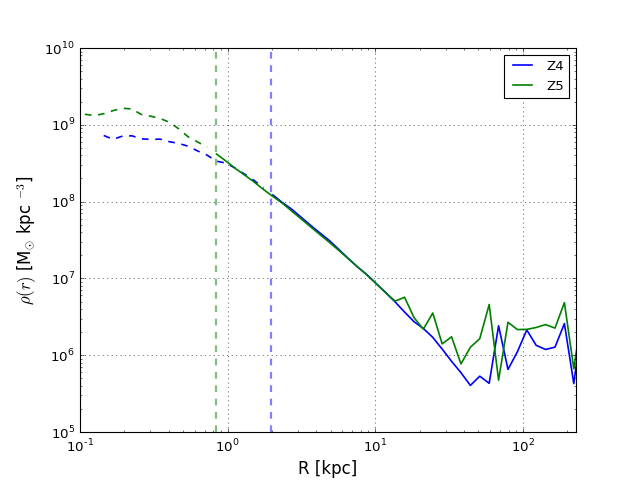

In [228]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_ylabel(r'$\rho(r)$ [M$_{\odot}$ kpc $^{-3}$]',fontsize=15)
ax.set_xlim([0.1,Z4.r200])
r = (r_p[:-1]+r_p[1:])/2.
ax.plot(r[(r<R_P03_Z4)],meanZ4[(r<R_P03_Z4)],'b--',lw=1.5)
ax.plot(r[(r>R_P03_Z4)],meanZ4[(r>R_P03_Z4)],'b-',lw=1.5,label='Z4')

ax.plot(r[(r<R_P03_Z5)],meanZ5[(r<R_P03_Z5)],'g--',lw=1.5)
ax.plot(r[(r>R_P03_Z5)],meanZ5[(r>R_P03_Z5)],'g-',lw=1.5,label="Z5")

ax.axvline(x=R_P03_Z4,color='b',ls='--',alpha=0.5, lw=2)
ax.axvline(x=R_P03_Z5,color='g',ls='--',alpha=0.5, lw=2)
legend = ax.legend(loc='bottom left', ncol=1, shadow=False, fontsize=12)

In [229]:
25**3


15625

In [148]:
hist_z4,binsz4 = np.histogram(Z4.dm.v[(Z4.dm.r>7.5)&(Z4.dm.r<8.5)&(np.abs(Z4.dm.pos3d[:,2])<0.5)])
Ntot_z4 = float(len(Z4.dm.v[(Z4.dm.r>7.5)&(Z4.dm.r<8.5)&(np.abs(Z4.dm.pos3d[:,2])<0.5)]))
hist_z5,binsz5 = np.histogram(Z5.dm.v[(Z5.dm.r>7.5)&(Z5.dm.r<8.5)&(np.abs(Z5.dm.pos3d[:,2])<0.5)])
Ntot_z5 = float(len(Z5.dm.v[(Z5.dm.r>7.5)&(Z5.dm.r<8.5)&(np.abs(Z5.dm.pos3d[:,2])<0.5)]))


<IPython.core.display.Javascript object>


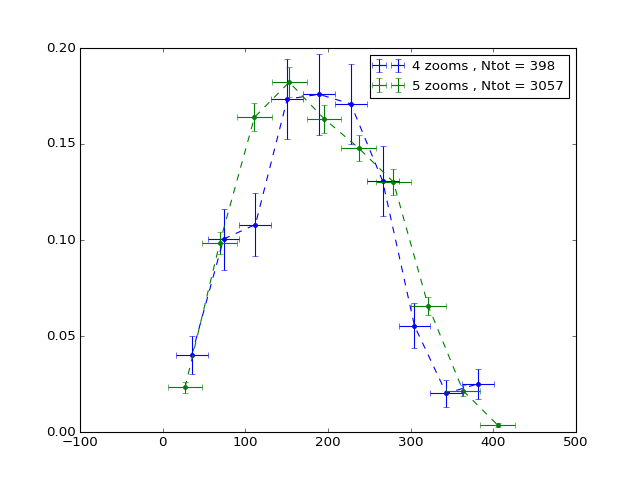

In [149]:
fig, ax = plt.subplots()
ax.set_ylim([0,0.2])
binsz4cen = (binsz4[:-1] + binsz4[1:])/2.
binsz5cen = (binsz5[:-1] + binsz5[1:])/2.
binsz4_width = binsz4[1]-binsz4[0]
binsz5_width = binsz5[1]-binsz5[0]

ax.errorbar(binsz4cen,hist_z4 / Ntot_z4,xerr=binsz4_width/2.,label="4 zooms , Ntot = {0}".format(int(Ntot_z4)),
            ls='--',yerr=np.sqrt(hist_z4)/Ntot_z4)
ax.scatter(binsz4cen,hist_z4 / Ntot_z4,c='b',linewidths=0)
ax.errorbar(binsz5cen,hist_z5 / Ntot_z5,xerr=binsz5_width/2.,label="5 zooms , Ntot = {0}".format(int(Ntot_z5)),
            ls='--',yerr=np.sqrt(hist_z5)/Ntot_z5)
ax.scatter(binsz5cen,hist_z5 / Ntot_z5,c='g',linewidths=0)

legend = ax.legend(loc='bottom left', ncol=1, shadow=False, fontsize=12)
#ax.bar(binsz5cen,hist_z5,width=binsz5_width,color='b',alpha=0.5)

In [168]:
rmin, rmax = 7.5, 8.5
zlim = 0.5

hist_z4,binsz4 = np.histogram(Z4.dm.v[(Z4.dm.r>rmin)&(Z4.dm.r<rmax)&(np.abs(Z4.dm.pos3d[:,2])<zlim)])
Ntot_z4 = float(len(Z4.dm.v[(Z4.dm.r>rmin)&(Z4.dm.r<rmax)&(np.abs(Z4.dm.pos3d[:,2])<zlim)]))
hist_z5,binsz5 = np.histogram(Z5.dm.v[(Z5.dm.r>rmin)&(Z5.dm.r<rmax)&(np.abs(Z5.dm.pos3d[:,2])<zlim)])
Ntot_z5 = float(len(Z5.dm.v[(Z5.dm.r>rmin)&(Z5.dm.r<rmax)&(np.abs(Z5.dm.pos3d[:,2])<zlim)]))


hist_z4_shell,binsz4_shell = np.histogram(Z4.dm.v[(Z4.dm.r>rmin)&(Z4.dm.r<rmax)],bins=12)
Ntot_z4_shell = float(len(Z4.dm.v[(Z4.dm.r>rmin)&(Z4.dm.r<rmax)]))
hist_z5_shell,binsz5_shell = np.histogram(Z5.dm.v[(Z5.dm.r>rmin)&(Z5.dm.r<rmax)],bins=12)
Ntot_z5_shell = float(len(Z5.dm.v[(Z5.dm.r>rmin)&(Z5.dm.r<rmax)]))


In [169]:
print np.sum(hist_z4_shell), Ntot_z4_shell


5201 5201.0


<IPython.core.display.Javascript object>


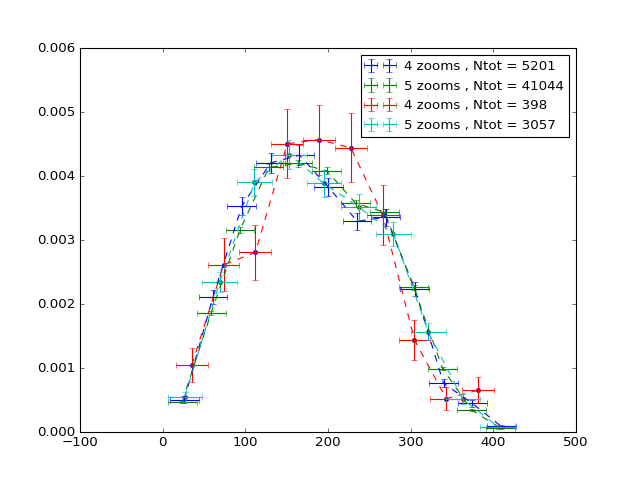

In [170]:
fig, ax = plt.subplots()
ax.set_ylim([0,0.006])
binsz4cen_shell = (binsz4_shell[:-1] + binsz4_shell[1:])/2.
binsz5cen_shell = (binsz5_shell[:-1] + binsz5_shell[1:])/2.
binsz4_width_shell = binsz4_shell[1]-binsz4_shell[0]
binsz5_width_shell = binsz5_shell[1]-binsz5_shell[0]

ax.errorbar(binsz4cen_shell,hist_z4_shell/ Ntot_z4_shell/binsz4_width_shell,xerr=binsz4_width_shell/2.,label="4 zooms , Ntot = {0}".format(int(Ntot_z4_shell)),
            ls='--',yerr=np.sqrt(hist_z4_shell)/Ntot_z4_shell/binsz4_width_shell)
#ax.scatter(binsz4cen_shell,hist_z4_shell / Ntot_z4_shell,c='b',linewidths=0)
ax.errorbar(binsz5cen_shell,hist_z5_shell / Ntot_z5_shell/binsz5_width_shell,xerr=binsz5_width_shell/2.,label="5 zooms , Ntot = {0}".format(int(Ntot_z5_shell)),
            ls='--',yerr=np.sqrt(hist_z5_shell)/Ntot_z5_shell/binsz5_width_shell)
#ax.scatter(binsz5cen_shell,hist_z5_shell/ Ntot_z5_shell,c='g',linewidths=0)

legend = ax.legend(loc='bottom left', ncol=1, shadow=False, fontsize=12)
#ax.bar(binsz5cen,hist_z5,width=binsz5_width,color='b',alpha=0.5)

binsz4cen = (binsz4[:-1] + binsz4[1:])/2.
binsz5cen = (binsz5[:-1] + binsz5[1:])/2.
binsz4_width = binsz4[1]-binsz4[0]
binsz5_width = binsz5[1]-binsz5[0]

ax.errorbar(binsz4cen,hist_z4 / Ntot_z4/binsz4_width,xerr=binsz4_width/2.,label="4 zooms , Ntot = {0}".format(int(Ntot_z4)),
            ls='--',yerr=np.sqrt(hist_z4)/Ntot_z4/binsz4_width)
ax.scatter(binsz4cen,hist_z4 / Ntot_z4/binsz4_width,c='b',linewidths=0)
ax.errorbar(binsz5cen,hist_z5 / Ntot_z5/binsz5_width,xerr=binsz5_width/2.,label="5 zooms , Ntot = {0}".format(int(Ntot_z5)),
            ls='--',yerr=np.sqrt(hist_z5)/Ntot_z5/binsz5_width_shell)
ax.scatter(binsz5cen,hist_z5 / Ntot_z5/binsz5_width,c='g',linewidths=0)

legend = ax.legend(loc='bottom left', ncol=1, shadow=False, fontsize=12)


<IPython.core.display.Javascript object>


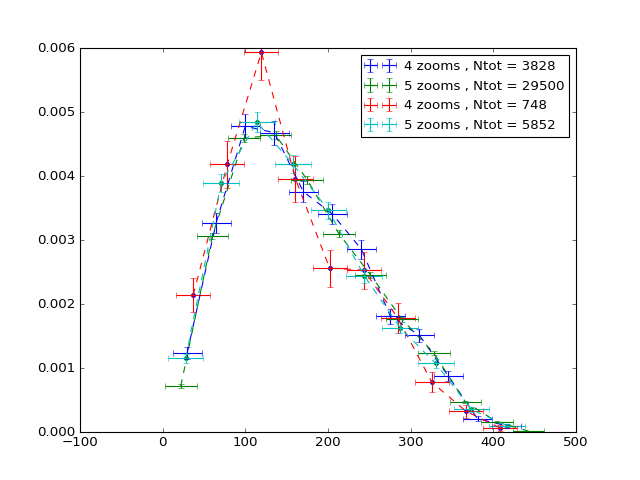

In [171]:
rmin, rmax = 2.5, 3.5
zlim = 0.5

hist_z4,binsz4 = np.histogram(Z4.dm.v[(Z4.dm.r>rmin)&(Z4.dm.r<rmax)&(np.abs(Z4.dm.pos3d[:,2])<zlim)])
Ntot_z4 = float(len(Z4.dm.v[(Z4.dm.r>rmin)&(Z4.dm.r<rmax)&(np.abs(Z4.dm.pos3d[:,2])<zlim)]))
hist_z5,binsz5 = np.histogram(Z5.dm.v[(Z5.dm.r>rmin)&(Z5.dm.r<rmax)&(np.abs(Z5.dm.pos3d[:,2])<zlim)])
Ntot_z5 = float(len(Z5.dm.v[(Z5.dm.r>rmin)&(Z5.dm.r<rmax)&(np.abs(Z5.dm.pos3d[:,2])<zlim)]))


hist_z4_shell,binsz4_shell = np.histogram(Z4.dm.v[(Z4.dm.r>rmin)&(Z4.dm.r<rmax)],bins=12)
Ntot_z4_shell = float(len(Z4.dm.v[(Z4.dm.r>rmin)&(Z4.dm.r<rmax)]))
hist_z5_shell,binsz5_shell = np.histogram(Z5.dm.v[(Z5.dm.r>rmin)&(Z5.dm.r<rmax)],bins=12)
Ntot_z5_shell = float(len(Z5.dm.v[(Z5.dm.r>rmin)&(Z5.dm.r<rmax)]))


fig, ax = plt.subplots()
ax.set_ylim([0,0.006])
binsz4cen_shell = (binsz4_shell[:-1] + binsz4_shell[1:])/2.
binsz5cen_shell = (binsz5_shell[:-1] + binsz5_shell[1:])/2.
binsz4_width_shell = binsz4_shell[1]-binsz4_shell[0]
binsz5_width_shell = binsz5_shell[1]-binsz5_shell[0]

ax.errorbar(binsz4cen_shell,hist_z4_shell/ Ntot_z4_shell/binsz4_width_shell,xerr=binsz4_width_shell/2.,label="4 zooms , Ntot = {0}".format(int(Ntot_z4_shell)),
            ls='--',yerr=np.sqrt(hist_z4_shell)/Ntot_z4_shell/binsz4_width_shell)
#ax.scatter(binsz4cen_shell,hist_z4_shell / Ntot_z4_shell,c='b',linewidths=0)
ax.errorbar(binsz5cen_shell,hist_z5_shell / Ntot_z5_shell/binsz5_width_shell,xerr=binsz5_width_shell/2.,label="5 zooms , Ntot = {0}".format(int(Ntot_z5_shell)),
            ls='--',yerr=np.sqrt(hist_z5_shell)/Ntot_z5_shell/binsz5_width_shell)
#ax.scatter(binsz5cen_shell,hist_z5_shell/ Ntot_z5_shell,c='g',linewidths=0)

legend = ax.legend(loc='bottom left', ncol=1, shadow=False, fontsize=12)
#ax.bar(binsz5cen,hist_z5,width=binsz5_width,color='b',alpha=0.5)

binsz4cen = (binsz4[:-1] + binsz4[1:])/2.
binsz5cen = (binsz5[:-1] + binsz5[1:])/2.
binsz4_width = binsz4[1]-binsz4[0]
binsz5_width = binsz5[1]-binsz5[0]

ax.errorbar(binsz4cen,hist_z4 / Ntot_z4/binsz4_width,xerr=binsz4_width/2.,label="4 zooms , Ntot = {0}".format(int(Ntot_z4)),
            ls='--',yerr=np.sqrt(hist_z4)/Ntot_z4/binsz4_width)
ax.scatter(binsz4cen,hist_z4 / Ntot_z4/binsz4_width,c='b',linewidths=0)
ax.errorbar(binsz5cen,hist_z5 / Ntot_z5/binsz5_width,xerr=binsz5_width/2.,label="5 zooms , Ntot = {0}".format(int(Ntot_z5)),
            ls='--',yerr=np.sqrt(hist_z5)/Ntot_z5/binsz5_width_shell)
ax.scatter(binsz5cen,hist_z5 / Ntot_z5/binsz5_width,c='g',linewidths=0)

legend = ax.legend(loc='bottom left', ncol=1, shadow=False, fontsize=12)


<IPython.core.display.Javascript object>


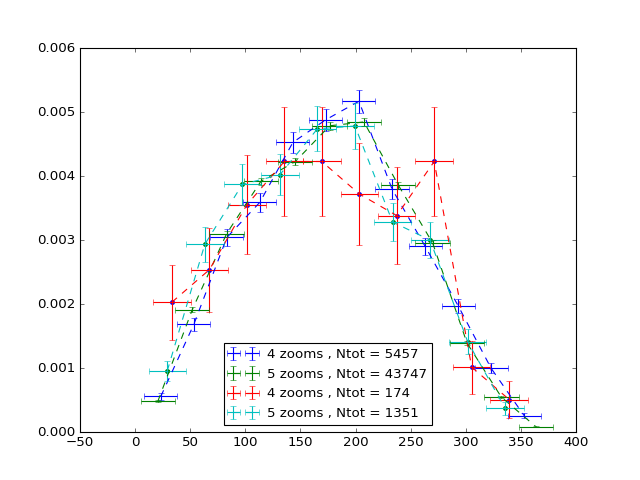

In [172]:
rmin, rmax = 19.5, 20.5
zlim = 0.5

hist_z4,binsz4 = np.histogram(Z4.dm.v[(Z4.dm.r>rmin)&(Z4.dm.r<rmax)&(np.abs(Z4.dm.pos3d[:,2])<zlim)])
Ntot_z4 = float(len(Z4.dm.v[(Z4.dm.r>rmin)&(Z4.dm.r<rmax)&(np.abs(Z4.dm.pos3d[:,2])<zlim)]))
hist_z5,binsz5 = np.histogram(Z5.dm.v[(Z5.dm.r>rmin)&(Z5.dm.r<rmax)&(np.abs(Z5.dm.pos3d[:,2])<zlim)])
Ntot_z5 = float(len(Z5.dm.v[(Z5.dm.r>rmin)&(Z5.dm.r<rmax)&(np.abs(Z5.dm.pos3d[:,2])<zlim)]))


hist_z4_shell,binsz4_shell = np.histogram(Z4.dm.v[(Z4.dm.r>rmin)&(Z4.dm.r<rmax)],bins=12)
Ntot_z4_shell = float(len(Z4.dm.v[(Z4.dm.r>rmin)&(Z4.dm.r<rmax)]))
hist_z5_shell,binsz5_shell = np.histogram(Z5.dm.v[(Z5.dm.r>rmin)&(Z5.dm.r<rmax)],bins=12)
Ntot_z5_shell = float(len(Z5.dm.v[(Z5.dm.r>rmin)&(Z5.dm.r<rmax)]))


fig, ax = plt.subplots()
ax.set_ylim([0,0.006])
binsz4cen_shell = (binsz4_shell[:-1] + binsz4_shell[1:])/2.
binsz5cen_shell = (binsz5_shell[:-1] + binsz5_shell[1:])/2.
binsz4_width_shell = binsz4_shell[1]-binsz4_shell[0]
binsz5_width_shell = binsz5_shell[1]-binsz5_shell[0]

ax.errorbar(binsz4cen_shell,hist_z4_shell/ Ntot_z4_shell/binsz4_width_shell,xerr=binsz4_width_shell/2.,label="4 zooms , Ntot = {0}".format(int(Ntot_z4_shell)),
            ls='--',yerr=np.sqrt(hist_z4_shell)/Ntot_z4_shell/binsz4_width_shell)
#ax.scatter(binsz4cen_shell,hist_z4_shell / Ntot_z4_shell,c='b',linewidths=0)
ax.errorbar(binsz5cen_shell,hist_z5_shell / Ntot_z5_shell/binsz5_width_shell,xerr=binsz5_width_shell/2.,label="5 zooms , Ntot = {0}".format(int(Ntot_z5_shell)),
            ls='--',yerr=np.sqrt(hist_z5_shell)/Ntot_z5_shell/binsz5_width_shell)
#ax.scatter(binsz5cen_shell,hist_z5_shell/ Ntot_z5_shell,c='g',linewidths=0)

legend = ax.legend(loc='bottom left', ncol=1, shadow=False, fontsize=12)
#ax.bar(binsz5cen,hist_z5,width=binsz5_width,color='b',alpha=0.5)

binsz4cen = (binsz4[:-1] + binsz4[1:])/2.
binsz5cen = (binsz5[:-1] + binsz5[1:])/2.
binsz4_width = binsz4[1]-binsz4[0]
binsz5_width = binsz5[1]-binsz5[0]

ax.errorbar(binsz4cen,hist_z4 / Ntot_z4/binsz4_width,xerr=binsz4_width/2.,label="4 zooms , Ntot = {0}".format(int(Ntot_z4)),
            ls='--',yerr=np.sqrt(hist_z4)/Ntot_z4/binsz4_width)
ax.scatter(binsz4cen,hist_z4 / Ntot_z4/binsz4_width,c='b',linewidths=0)
ax.errorbar(binsz5cen,hist_z5 / Ntot_z5/binsz5_width,xerr=binsz5_width/2.,label="5 zooms , Ntot = {0}".format(int(Ntot_z5)),
            ls='--',yerr=np.sqrt(hist_z5)/Ntot_z5/binsz5_width_shell)
ax.scatter(binsz5cen,hist_z5 / Ntot_z5/binsz5_width,c='g',linewidths=0)

legend = ax.legend(loc='bottom left', ncol=1, shadow=False, fontsize=12)


In [1]:
rmin, rmax = 122.5, 123.5
zlim = 0.5

hist_z4,binsz4 = np.histogram(Z4.dm.v[(Z4.dm.r>rmin)&(Z4.dm.r<rmax)&(np.abs(Z4.dm.pos3d[:,2])<zlim)])
Ntot_z4 = float(len(Z4.dm.v[(Z4.dm.r>rmin)&(Z4.dm.r<rmax)&(np.abs(Z4.dm.pos3d[:,2])<zlim)]))
hist_z5,binsz5 = np.histogram(Z5.dm.v[(Z5.dm.r>rmin)&(Z5.dm.r<rmax)&(np.abs(Z5.dm.pos3d[:,2])<zlim)])
Ntot_z5 = float(len(Z5.dm.v[(Z5.dm.r>rmin)&(Z5.dm.r<rmax)&(np.abs(Z5.dm.pos3d[:,2])<zlim)]))


hist_z4_shell,binsz4_shell = np.histogram(Z4.dm.v[(Z4.dm.r>rmin)&(Z4.dm.r<rmax)],bins=12)
Ntot_z4_shell = float(len(Z4.dm.v[(Z4.dm.r>rmin)&(Z4.dm.r<rmax)]))
hist_z5_shell,binsz5_shell = np.histogram(Z5.dm.v[(Z5.dm.r>rmin)&(Z5.dm.r<rmax)],bins=12)
Ntot_z5_shell = float(len(Z5.dm.v[(Z5.dm.r>rmin)&(Z5.dm.r<rmax)]))


fig, ax = plt.subplots()
ax.set_ylim([0,0.008])
binsz4cen_shell = (binsz4_shell[:-1] + binsz4_shell[1:])/2.
binsz5cen_shell = (binsz5_shell[:-1] + binsz5_shell[1:])/2.
binsz4_width_shell = binsz4_shell[1]-binsz4_shell[0]
binsz5_width_shell = binsz5_shell[1]-binsz5_shell[0]

ax.errorbar(binsz4cen_shell,hist_z4_shell/ Ntot_z4_shell/binsz4_width_shell,xerr=binsz4_width_shell/2.,label="4 zooms , Ntot = {0}".format(int(Ntot_z4_shell)),
            ls='--',yerr=np.sqrt(hist_z4_shell)/Ntot_z4_shell/binsz4_width_shell)
#ax.scatter(binsz4cen_shell,hist_z4_shell / Ntot_z4_shell,c='b',linewidths=0)
ax.errorbar(binsz5cen_shell,hist_z5_shell / Ntot_z5_shell/binsz5_width_shell,xerr=binsz5_width_shell/2.,label="5 zooms , Ntot = {0}".format(int(Ntot_z5_shell)),
            ls='--',yerr=np.sqrt(hist_z5_shell)/Ntot_z5_shell/binsz5_width_shell)
#ax.scatter(binsz5cen_shell,hist_z5_shell/ Ntot_z5_shell,c='g',linewidths=0)

legend = ax.legend(loc='bottom left', ncol=1, shadow=False, fontsize=12)
#ax.bar(binsz5cen,hist_z5,width=binsz5_width,color='b',alpha=0.5)

binsz4cen = (binsz4[:-1] + binsz4[1:])/2.
binsz5cen = (binsz5[:-1] + binsz5[1:])/2.
binsz4_width = binsz4[1]-binsz4[0]
binsz5_width = binsz5[1]-binsz5[0]

ax.errorbar(binsz4cen,hist_z4 / Ntot_z4/binsz4_width,xerr=binsz4_width/2.,label="4 zooms , Ntot = {0}".format(int(Ntot_z4)),
            ls='--',yerr=np.sqrt(hist_z4)/Ntot_z4/binsz4_width)
ax.scatter(binsz4cen,hist_z4 / Ntot_z4/binsz4_width,c='b',linewidths=0)
ax.errorbar(binsz5cen,hist_z5 / Ntot_z5/binsz5_width,xerr=binsz5_width/2.,label="5 zooms , Ntot = {0}".format(int(Ntot_z5)),
            ls='--',yerr=np.sqrt(hist_z5)/Ntot_z5/binsz5_width_shell)
ax.scatter(binsz5cen,hist_z5 / Ntot_z5/binsz5_width,c='g',linewidths=0)

legend = ax.legend(loc='bottom left', ncol=1, shadow=False, fontsize=12)


NameError: name 'np' is not defined

In [14]:
print (False + False), (False +True), (True+True)

0 1 2
